# Machine learning models
In this section we will introduce the models we will use and the techniques to deal wit our imbalance dataset. From the previosu analysis done in the previous notebook we stubled upon the question: **Is it possible to figure out what variables will be the most influential using only statistical means?** The initial answer seems to be favorable althogh more research should be done in the future.
# Outline
*[Validation and training datasets](#Validation-and-training-datasets)<br>
*[Imbalanced data](#Imbalanced-data)<br>
*[Machine Learning models](#Machine-Learning-models)<br> 
*[Metrics](#Metrics)<br>
*[Visualization](#Visualization)<br>
*[Hyperparameters](#Hyperparameters)<br>
*[Influential variables](#Influential-variables)<br>
*[Deep Learning](#Deep-Learning)<br>
*[Conclusions](Conclusions)<br>




In [17]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score


We import our clean dataset

In [10]:
#dftest2
import pickle
#pickle.dump(dftest2, open("card_df_standard.pkl", "wb"))
dftest2 = pickle.load(open("card_df_standard.pkl","rb"))
#dftest2

# Validation and training datasets


We create a function to extract the features and labels of the datafreame and save them separatedly in X and Y

In [11]:
def dataset_generator(dataset,  train=True): 
    Y = dataset["Class"].to_numpy() #Convert quality dataset to array
    if train:
            X = dataset.drop(["Class", "Time"], axis=1).to_numpy()  #drop extra columns and convert to array
            
    else:
            X = dataset.drop("Class", axis=1).to_numpy()  #drop extra columns and convert to array
        
    return X,Y

In [13]:
#Generate features and labels sets
X,Y=dataset_generator(dftest2)
print(X.shape, Y.shape)


(196619, 30) (196619,)


This function will shuffle our examples. We need it since the outputs of the undersampling and oversampling functions from sklearn produce sets of samples separated by class. 

In [14]:
#Function for shuffling subsamples
def create_sample_dataset(existing_X, existing_Y, size):
    """Create a single sample dataset"""
    
    idxs = np.random.choice(np.arange(len(existing_X)), size=size, replace=False) # , replace=True if you want randomly sample indices with replacement
    return existing_X[idxs], existing_Y[idxs] # return examples at these indices


## Validation dataset

In [15]:
#Get a validation and training set use sklearn
from collections import Counter
from sklearn.model_selection import train_test_split

## randomly split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,test_size=0.2, shuffle=True, stratify=Y)
print("Size of training data:",Y_train.shape[0], "Size of validation data",Y_val.shape[0])
print("Training set, Valid (0), Fraud (1): ",Counter(Y_train),"\n","Validation set, Valid (0), Fraud(1): ",Counter(Y_val))

Size of training data: 157295 Size of validation data 39324
Training set, Valid (0), Fraud (1):  Counter({0: 157017, 1: 278}) 
 Validation set, Valid (0), Fraud(1):  Counter({0: 39255, 1: 69})


### Test dataset

In [8]:
#Getting a test set
test_df = pd.read_csv('creditcard_test.csv')
#test_df

In [18]:
#Standardizing all the variables of my dataframe (Vi, Amount and  Time)

def df_to_standard(dataset):
    
    data_features = StandardScaler().fit_transform(dataset.drop(["Class"],axis=1))    # standariced data
    data_features = np.concatenate((data_features,dataset["Class"].values.reshape(-1,1)), axis=1)
    
    #Columns and indexes for the new dataframe
    columns_df=dataset.columns.tolist()
    indexes_df=dataset.index.tolist()

    #Creating data frame for standarized data
    newdf = pd.DataFrame(data_features, index=indexes_df, columns=columns_df)
    #dftest2
    return newdf

test_df_std= df_to_standard(test_df)
#test_df_std


In [19]:
#Generate features and labels sets for the trainning set
X_test,Y_test=dataset_generator(test_df_std, train=False)
print(X_test.shape, Y_test.shape)

(85443, 30) (85443,)


# Imbalanced data
## Undersampling versus oversampling


Imbalance datasets occur when we have in our dataset small samples of a particular class (minority class) compared to the other classes (majority class).  In other words, it occurs when the class distribution is highly non uniform among the classes. This will present a problem for our models  since they will be prone to have high accuracies by just predicting the majority class but fail to predict the minority class which normally is the whole point of the model.
In the context of binary classification we have the majority class (negative) and the minority (positive) class. The terms "positive" and "negative" do not refer to benefit, but to the presence or absence of a condition; for example if the condition is a disease, "positive" means "diseased" and "negative" means "healthy”.[ref.](https://en.wikipedia.org/wiki/Sensitivity_and_specificity). <br>


Two main techniques are used to deal with this problem: <br>

* **Undersampling:** It reduces the size of the majority class. In other words, it keeps all the elements of the minority class and randomly selects an equal number of elements from the majority class  thus creating a balanced dataset.<br>
* **Oversampling:** This technique focuses on the minority class by increasing  its size. In other words, new elements belonging to the minority class are generated using repetition (bootstrapping) or creating synthetic elements (SMOTE).
In this project, we will be testing variations  based on the two main techniques described above. Using the python package imbalanced-learn (imblearn) [ref1.](https://github.com/scikit-learn-contrib/imbalanced-learn#id3
) [ref.2](https://imbalanced-learn.org/stable/)<br>
	a) **Random Undersampling:** As described above takes n random elements from the majority class and balances with n equal to the size of the minority class.<br>
	b) **Random Oversampling:** Selects random elements with replacement from the minority class until the size is equal to m where m is the size of the majority class.<br>
	c) **Undersampling:** using Tomek-Links: Tomek links are pairs of examples of opposite classes in close vicinity.
In this algorithm, we end up removing the majority element from the Tomek link, which provides a better decision boundary for a classifier. [ref1.](https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html) [ref2.](https://imbalanced-learn.org/stable/under_sampling.html#tomek-links)<br>
	d) **Oversampling using SMOTE:** In SMOTE (Synthetic Minority Oversampling Technique) we synthesize elements for the minority class, in the vicinity of already existing elements. [ref.](https://arxiv.org/pdf/1106.1813.pdf)<br>
	e) **Undersampling using Clusters:** Instead of relying on random samples to select from the majority class, we  clustering the majority class (Usually a K-means method) in r groups, with r being the number of elements in the minority class For each group, only the medoid (centre of cluster) is kept. The model is then trained with the minority  class and the medoids only. [ref.](https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.ClusterCentroids.html)<br>

## Creating balanced datasets
In the following we use the package imblearn to create our balanced samples. 

### OverSampling


* **Random oversampling**

In [28]:
#Random oversampling
from imblearn.over_sampling import RandomOverSampler

X_ros, Y_ros = RandomOverSampler().fit_resample(X_train,Y_train)  #Create samples
X_ros.shape

#print(list(Y_ros))
X_ros, Y_ros= create_sample_dataset(X_ros, Y_ros, len(Y_ros))  #Shuffling results

#print(list(Y_ros))
Counter(Y_ros)    #Confirming number of samples of each class


Counter({0: 157017, 1: 157017})

* **SMOTE**

In [48]:
#SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority') #Create synthetic data from the minority class
X_sm, Y_sm = smote.fit_sample(X_train, Y_train)

X_sm, Y_sm= create_sample_dataset(X_sm, Y_sm, len(Y_sm))   #Shuffling results

Counter(Y_sm)                             #Confirming number of samples of each class

Counter({0: 157017, 1: 157017})

### UnderSampling



* **Random undersampling**

In [21]:
#Random undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, Y_rus=rus.fit_resample(X_train,Y_train)      #Resampling majority class


X_rus, Y_rus= create_sample_dataset(X_rus, Y_rus, len(Y_rus))  #Shuffling results


Counter(Y_rus)           #Confirming number of samples of each class

Counter({1: 278, 0: 278})

* **Tomek Links**

In [50]:
#Undersample: Tomeklinks
from imblearn.under_sampling import TomekLinks

#Reduce the majority sample to end up with a ratio of 45/55=.81 (minority/majority) 
X_, Y_ = RandomUnderSampler(sampling_strategy = .81).fit_resample(X_train,Y_train) 
#print(Counter(Y_))


X_tk,Y_tk=TomekLinks().fit_resample(X_, Y_)        #Apply Tomek Links and eliminate the extra elements of the majority sample

X_tk, Y_tk= create_sample_dataset(X_tk, Y_tk, len(Y_tk)) #Shuffling results

Counter(Y_tk)             #Confirming number of samples of each class

Counter({0: 343, 1: 278})


Counter({0: 337, 1: 278})

* **Clustering**

In [63]:
#Undersample: Clustering the abundant class
from imblearn.under_sampling import ClusterCentroids

X_clus, Y_clus = ClusterCentroids().fit_resample(X_train,Y_train)  #Clustering majority class

X_clus, Y_clus = create_sample_dataset(X_clus, Y_clus, len(Y_clus))  #Shuffling results

Counter(Y_clus)                     #Confirming number of samples of each class

Counter({1: 278, 0: 278})

In [52]:
# Saving centroids 
import pickle

In [65]:
#pickle.dump(X_clus, open("X_clus.pkl", "wb"))
#pickle.dump(Y_clus, open("Y_clus.pkl", "wb"))

In [35]:
X_clus = pickle.load(open("X_clus.pkl","rb"))

Y_clus = pickle.load(open("Y_clus.pkl","rb"))


<a id="section_statistics_balanced_dataset"></a>

## Statistics of balanced dataset
Let us explore the statistics of the new balanced dataset. We are using arbitrarily the random undersampling dataset $X_{rus}$, $Y_{rus}$ but similar conclusions should be obtained from the other cases given that in general, subsamples of the  abundant class should also follow the same distribution of the original sample and similarly oversampling the smaller class is just adding more elements that follow an specific distribution into a bigger sample.<br>
The balance set clearly helped.  We can now distingish very defined correlations among the different varibles Vi and also with the column Class.


In [32]:
#Creating heatmap random undersampling
data_XY=np.concatenate((X_rus,Y_rus.reshape(-1,1)), axis=1) #change to X_rus
#print(X_rus.shape, Y_rus.reshape(-1,1).shape)

#Correlations
columns_scaled=dftest2.drop(["Time"], axis=1).columns
df_sampling = pd.DataFrame(data_XY,  columns=columns_scaled)#index=indexes_df, X_rus
fig = px.imshow(df_sampling.corr(), title="Heatmap variables Vi random undersampling ")
fig.update_layout(height=650)
fig.show()

The correlation map show us the first 8 variables Vi that are highly correlated with the label Class. Something interesting we should emphasize is that the variables V10, V11, V12, V14 and V17 that showed the most difference between the peaks of the Class=0 and Class=1 distributions (section ["Distribution for the variables Vi"](./Credit card fraud1_EDA.ipynb#section_distributionsVi)) appear again but now for the correlations. We can start to suspect that these variables will play a significative role in our classification models. 

In [33]:
#Parameters with highest positive/negative correlation with Class V10, V11, V12, V14, V17
df_sampling.corr()['Class'].sort_values(key=lambda x: x.abs(), ascending=False)[1:10]

V14   -0.759076
V4     0.711726
V11    0.691778
V12   -0.689249
V10   -0.628835
V16   -0.588486
V3    -0.581094
V9    -0.563739
V17   -0.542232
Name: Class, dtype: float64

We still can see some outliers that could be removed if we apply a criteria such as $[4*Q1-3*Q3,  4*Q3-3*Q1 ]$, where a factor or 3 was used to calculate the lower and upper fences.[ref](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)<br>
$$
\text{Upper Fence} = Q3 + (3 * IQR) \\
\text{Lower Fence} = Q1 - (3 * IQR)
$$
However we will leave them as it is and potentially remove them once we have selected a ML model and a sampling method.

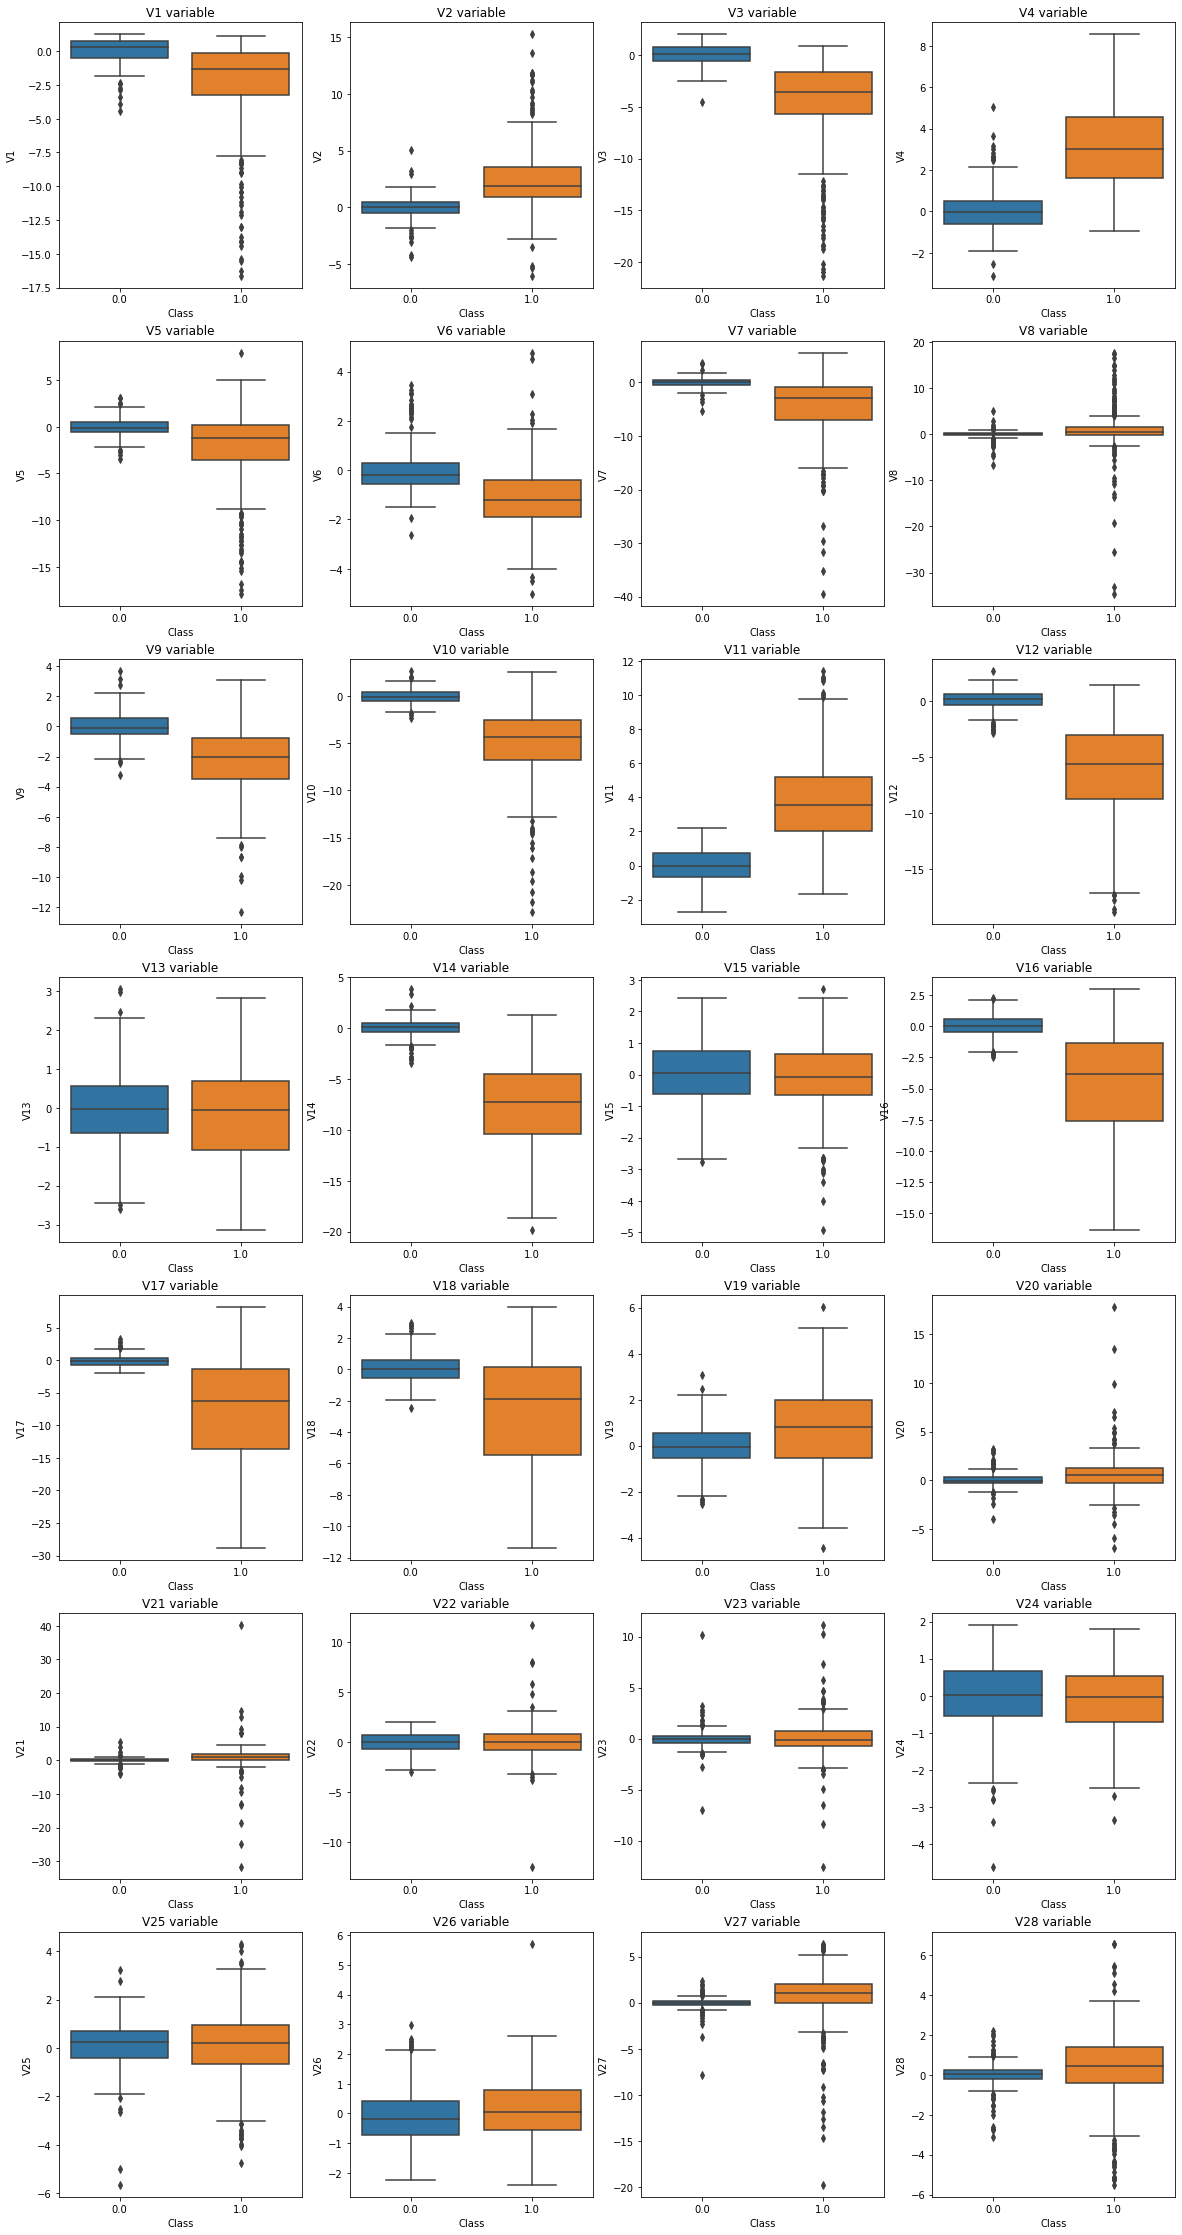

In [25]:
creditcard_Vs=test_df.drop(["Time","Amount", "Class"],axis=1)

f,axes=plt.subplots(ncols=4, nrows=7, figsize=(20,40))
#print(axes[0,0])
for i, Vi in enumerate(creditcard_Vs.columns.tolist()):
    row = (i // 4) 
    col = (i % 4) 
    #print(row, col)
    sns.boxplot(x="Class", y=Vi, data=df_sampling, ax=axes[row,col])
    axes[row,col].set_title(f'{Vi} variable')

The distributions below are just to show that they are essentially the same as the ones obtained in (section ["Distribution for the variables Vi"](./Credit card fraud1_EDA.ipynb#section_distributionsVi)) as it should be.

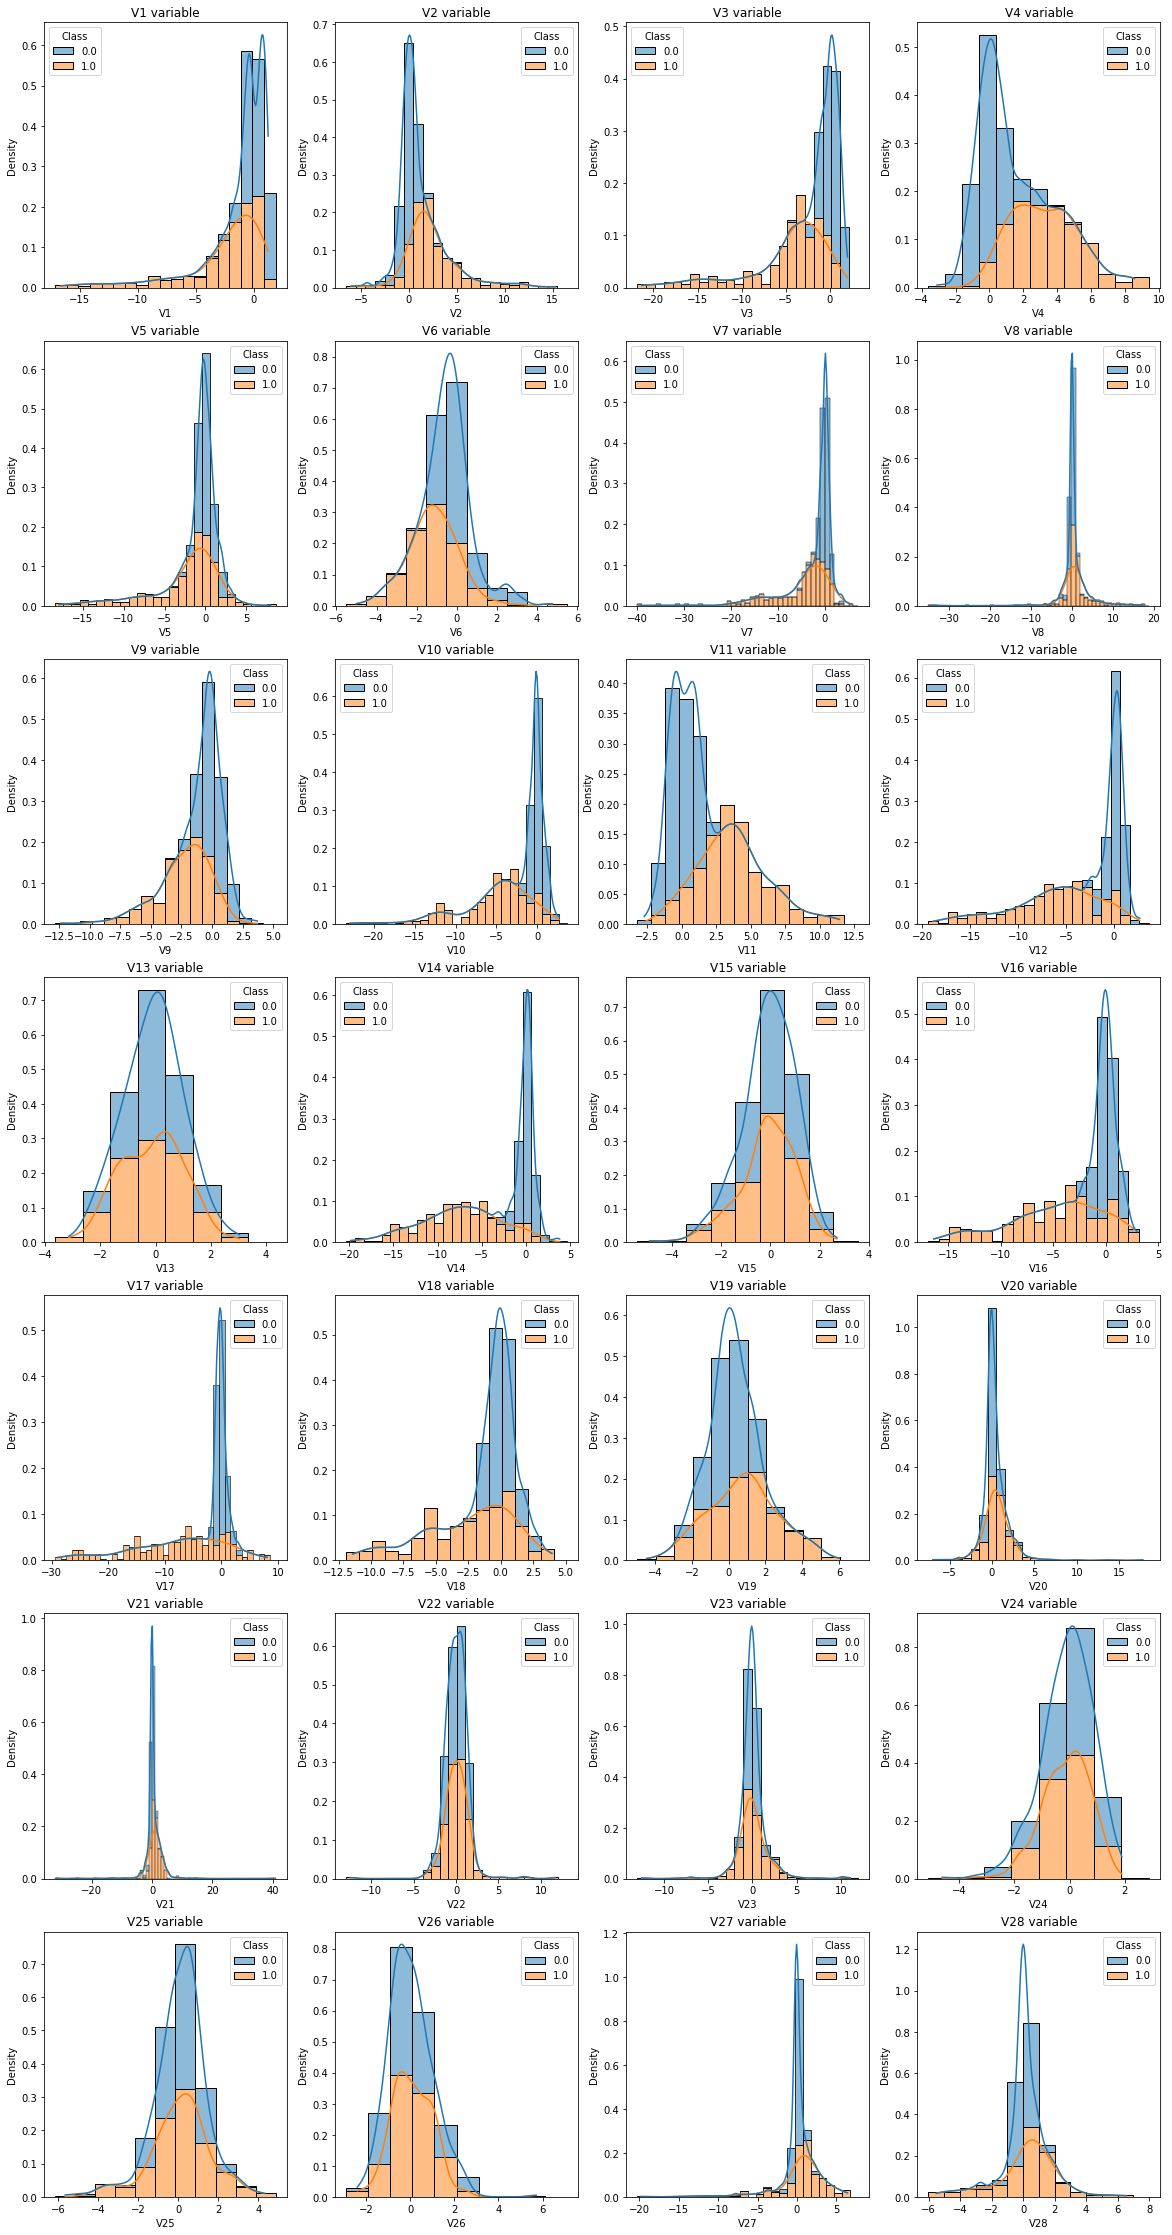

In [34]:
f,axes=plt.subplots(ncols=4, nrows=7, figsize=(20,40))
#print(axes[0,0])
for i, Vi in enumerate(creditcard_Vs.columns.tolist()):
    row = (i // 4) 
    col = (i % 4) 
    #print(row, col)
    sns.histplot(df_sampling, x=Vi, ax=axes[row,col], hue="Class", multiple="stack",discrete=True, stat="density", common_norm=False, kde=True)
    axes[row,col].set_title(f'{Vi} variable')

Also note how the correlation functions fot the other techniques are essentially the same.

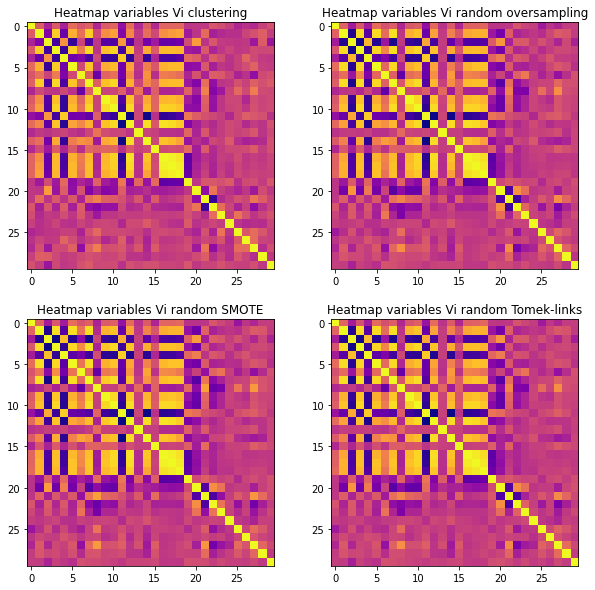

In [147]:

f,axes=plt.subplots(ncols=2, nrows=2, figsize=(10,10))
titles=["Heatmap variables Vi clustering",  "Heatmap variables Vi random oversampling",
               "Heatmap variables Vi random SMOTE","Heatmap variables Vi random Tomek-links"]
X_data=[X_clus, X_ros, X_sm, X_tk]
fig = make_subplots(2, 2, subplot_titles=titles)
for i, corr in enumerate(X_data):
    row = (i // 2)
    col = (i % 2) 
    columns_scaled=dftest2.drop(["Time", "Class"], axis=1).columns
    df_sampling = pd.DataFrame(corr,  columns=columns_scaled) #index=indexes_df,
    axes[row,col].imshow(df_sampling.corr(), cmap='plasma')
    axes[row,col].set_title(titles[i])
  

In [ ]:
#Implement methods to perform undersampling and oversampling. 
#make sure you have your validation set/training set before thaat in order to no make mistakes with cross validation.

# Metrics


An important ingredient  to evaluate the performance of our models are the metrics. As pointed out by the previous discussion, accuracy, the number of times a model makes a correct prediction, is not a good indicator when we want to detect rare cases of the minority class.  In order to define better metrics, lets remember some previous concepts .

In the context of binary classification, If we consider  two categories one to be 'Positive' and the other to be 'Negative', we can  categorize the prediction outcome under the following four categories:<br>

- __True positive:__ Where the model predicts the label to be 'Positive' and the true label is ‘Positive’<br>

- __True negative:__ Where the model predicts the label to be 'Negative' and the true label is 'Negative'<br>

- __False positive:__ Where the model predicts the label to be 'Positive' and the true label is 'Negative'<br>

- __False negative:__ Where the model predicts the label to be 'Negative' and the true label is 'Positive'<br>



These outcomes can be displayed in tabular form, in what is known as a  confusion matrix. From here we can define the following:<br>





__Precision__: Defined as the ratio of correctly predicted positives to the total number of predicted positives. Can be also thought as how many selected instances are relevant.<br>



$$ \text{Precision} = \frac{\text{True positives}}{\text{True positives + False positives}}$$



 __Recall__, Defined as the ratio of the correctly predicted positives to the total number of positives in the dataset. Alternatively, how many relevant instances are selected.<br>



$$\text{Recall} = \frac{\text{True positive}}{\text{True positive + False negative}}$$



Finally, the main metric we will be using. <br>

F1 score which is the harmonic mean of the precision and recall. The F1 score  maintains a balance between the precision and recall for our model. If your precision is low, the F1 is low, and if the recall is low again, your F1 score is low.<br>

$$F_{1} = 2\cdot \frac{\text{precision . recall}}{\text{precision + recall}} $$

As an illustrative example,     If you are a police inspector and you want to catch criminals, you want to be sure that the person you catch is a criminal (Precision) and you also want to capture as many criminals (Recall) as possible. The F1 score manages this tradeoff.[ref](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html) 


# Machine Learning models

We found in the literature various suggestions such as KNN and logistic regression [here](https://medium.com/@deepeshn1988/introduction-to-fraud-detection-systems-1786d696617) and [here](https://ieeexplore.ieee.org/abstract/document/8123782) with KNN performed among the best. Also boosting reccomended [here](https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html) arguing that some models are particularly suited for imbalanced datasets since we can give more weights to the cases that get misclassified in each tree iteration. Random forest was another popular [here](https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail).    Also [here](https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8) the author used a variety of models but selected random forest arguing that "it could easily be used to explain very simply why a certain decision was made" trait very useful in bussines. Also a few authors suggested NN as another application [here](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)<br>



Thus we will use Logistic regresssion, Random Forest, KNN, Adaboost and by testing over one of our balanced samples we will select the one that performs better so we can fine tune it. Finally as extra we also use Neural Networks in Pytorch as an ilustrative solution. 

First we define a function that can train our models and evaluate the metrics discused using the test data set. 






In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score


def Classification(model, X_train, Y_train, X_test, Y_test, plots=True):
    classifier=model.fit(X_train, Y_train)
    predictions=model.predict(X_test)
    #Using score to get accuracy: 
    score=model.score(X_test,Y_test)
    if plots:
        print("Accuracy:", score)
        cm = confusion_matrix( predictions ,Y_test, labels=[1, 0])
        print("Confusion Matrix \n", cm)
        #Plot confusion matrix
        disp = plot_confusion_matrix(classifier, X_test, Y_test,
                                     cmap=plt.cm.Blues,
                                     normalize="true", 
                                    display_labels=["Fraud: 1","Valid: 0" ]) #None "true"
        disp.ax_.set_title("Confusion matrix normalized")
        print("Confusion matrix normalized")
        print(disp.confusion_matrix)
        plt.show()
    
        print("F1 score: ", f1_score(Y_test, predictions))
        print("Recall: ", recall_score(Y_test, predictions))
        print("Precision: ", precision_score(Y_test, predictions))
        return model, predictions
    else: 
        return f1_score(Y_test, predictions), f1_score(Y_train,model.predict(X_train))



* Logistic Regression

Accuracy: 0.9786758423744485
Confusion Matrix 
 [[  114  1808]
 [   14 83507]]
Confusion matrix normalized
[[0.97880795 0.02119205]
 [0.109375   0.890625  ]]


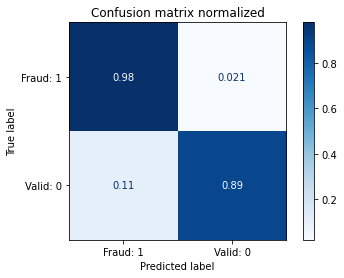

F1 score:  0.11121951219512195
Recall:  0.890625
Precision:  0.05931321540062435


In [69]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()

model_lr, predictions_lr=Classification(logisticRegr, X_ros, Y_ros, X_test, Y_test)


* Random Forest


Accuracy: 0.9977879990168884
Confusion Matrix 
 [[  102   163]
 [   26 85152]]
Confusion matrix normalized
[[0.99808943 0.00191057]
 [0.203125   0.796875  ]]


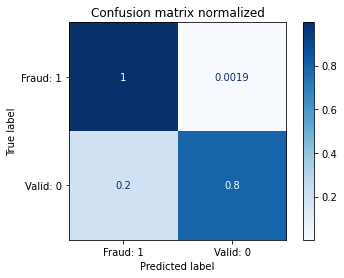

F1 score:  0.5190839694656488
Recall:  0.796875
Precision:  0.3849056603773585


In [91]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier(n_estimators=80, max_depth=2, max_samples=10) # init random forest
model_rf, prediction_rf=Classification(randomForest, X_ros, Y_ros, X_test, Y_test)


* KNN

Accuracy: 0.9992626663389628
Confusion Matrix 
 [[   97    32]
 [   31 85283]]
Confusion matrix normalized
[[9.99624919e-01 3.75080584e-04]
 [2.42187500e-01 7.57812500e-01]]


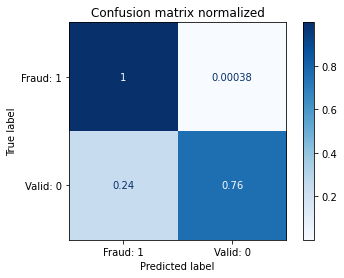

F1 score:  0.754863813229572
Recall:  0.7578125
Precision:  0.751937984496124


In [97]:
# KNN
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score

from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=2) #n_neighbors=3

modelKNN, predictions_KNN=Classification(KNN, X_ros, Y_ros, X_test, Y_test)


In [ ]:
#KNN.set_params(n_neighbors=2)

In [ ]:
#KNN.get_params()

* Adaboost

Accuracy: 0.9897475509989115
Confusion Matrix 
 [[  111   859]
 [   17 84456]]
Confusion matrix normalized
[[0.98993143 0.01006857]
 [0.1328125  0.8671875 ]]


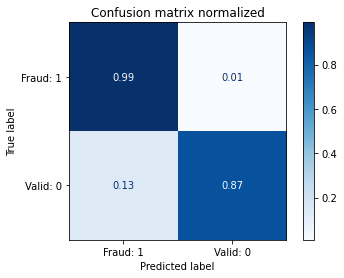

F1 score:  0.20218579234972675
Recall:  0.8671875
Precision:  0.11443298969072165


In [93]:
import sklearn.ensemble
adaBoost = sklearn.ensemble.AdaBoostClassifier()


model_Ada, prediction_Ada=Classification(adaBoost, X_ros, Y_ros, X_test, Y_test)

## Results

* Logistic regression F1 score:  0.11121951219512195
* Random Forest       F1 score:  0.5190839694656488
* KNN                 F1 score:  0.754863813229572  
* Adaboost            F1 score:  0.20218579234972675

# Visualization


## Dimensionality reduction and data visualization
We are using PCA to being able to visualize our data in 2D. Besides of visualizing the datapoints of the 2 classes, the algorithm draws the class regions where a point would be classified. The code is modified from this [this source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py)

In [123]:
# #############################################################################
# Visualize the results on PCA-reduced data
from sklearn.cluster import KMeans ## import kmeans model from sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def visualization(model, X_test, Y_test): 
    

    reduced_data = PCA(n_components=2).fit_transform(X_test)
    #print(reduced_data)
    model.fit(reduced_data, Y_test)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .2     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()  
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Accent,
           aspect='auto', origin='lower') #Paired
    for idx in list(set(Y_test)):
         #print(reduced_data[Y_ros==idx][:,0])
        plt.plot(reduced_data[Y_test == idx][:, 0], reduced_data[Y_test == idx][:, 1], 'k.', markersize=2,  c=str(idx), label=f"Class:{idx}")
    plt.legend()
    plt.title('Visualization of predictions of credit card data (PCA-reduced data)')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    #here

* Logistic Regression

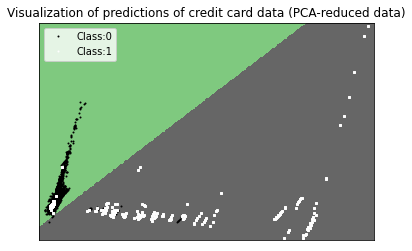

In [126]:
visualization(logisticRegr, X_ros, Y_ros)

* Random Forest

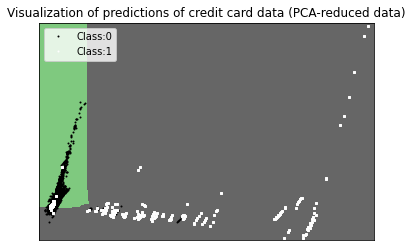

In [133]:

visualization(randomForest, X_ros, Y_ros)

* KNN

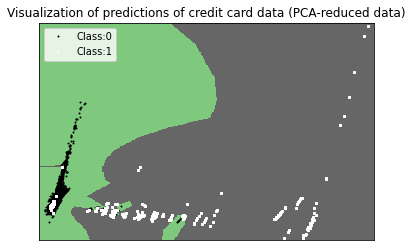

In [127]:
visualization(KNN, X_ros, Y_ros)

* Adaboost

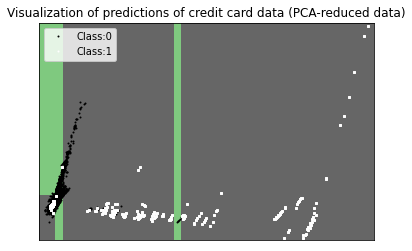

In [129]:
visualization(adaBoost, X_ros, Y_ros)

# Hyperparameters

Here we finetune our hyperparameters, in this case n_neighbors for the KNN model. In order to reduce computation time we are planning use the undersample data: X_rus, Y_rus to train the model before evaluating in the data set, instead of the oversampled data X_ros, Y_ros.

[]

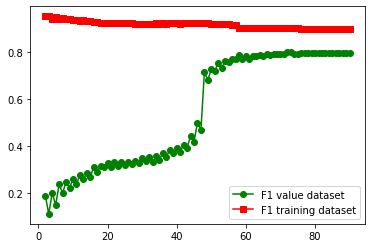

In [132]:
#Function to find hyperparameters
KNN = KNeighborsClassifier(n_neighbors=2) #n_neighbors=3
param=range(2, 91)

def hyper_search(model, parameters, X_train, Y_train, X_val, Y_val):
    F1=0
    optim_par=0
    F1_list=[]
    F1_list_train=[]
    for p in parameters:
        model_hyper=model.set_params(n_neighbors=p)
        F1_val, F1_train=Classification(model_hyper, X_train, Y_train, X_val, Y_val, plots=False)
        if F1_val>F1:
            F1=F1_val
            optim_par=p
        F1_list.append(F1_val)
        F1_list_train.append(F1_train)
    return F1, optim_par, F1_list, F1_list_train



F1, optim_par, F1_list, F1_list_train=hyper_search(KNN, param, X_rus, Y_rus, X_val, Y_val)

plt.plot(param, F1_list, 'go-', label='F1 value dataset')
plt.plot(param, F1_list_train, 'rs-',  label='F1 training dataset')
plt.legend()
plt.plot()

Optimal hyperparameter is:72

In [134]:
optim_par,F1

(72, 0.8)

In [135]:
F1_list

[0.1895734597156398,
 0.1111111111111111,
 0.20097244732576985,
 0.14903846153846154,
 0.23689320388349516,
 0.20032840722495895,
 0.24691358024691357,
 0.22140221402214022,
 0.2591792656587473,
 0.2380952380952381,
 0.2777777777777778,
 0.25862068965517243,
 0.28708133971291866,
 0.2702702702702703,
 0.30927835051546393,
 0.2912621359223301,
 0.3157894736842105,
 0.30927835051546393,
 0.32608695652173914,
 0.31007751937984496,
 0.33240997229916897,
 0.316622691292876,
 0.33240997229916897,
 0.3191489361702128,
 0.33146067415730335,
 0.32345013477088946,
 0.3361344537815126,
 0.32786885245901637,
 0.35119047619047616,
 0.3371428571428572,
 0.35542168674698793,
 0.33146067415730335,
 0.3575757575757576,
 0.34202898550724636,
 0.3722397476340694,
 0.35435435435435436,
 0.38436482084690554,
 0.36990595611285265,
 0.3920265780730897,
 0.375796178343949,
 0.4068965517241379,
 0.3933333333333333,
 0.44360902255639095,
 0.41843971631205673,
 0.5,
 0.46825396825396837,
 0.7151515151515152,
 0.

In [145]:
# params=[3, 5, 7, 10]

# F1_, optim_par_, F1_list_, F1_list_train_=hyper_search(KNN, params, X_ros, Y_ros, X_val, Y_val)


We need to improve our prediction for the hyperparameter, we evaluated n_neighbors=72 and we obtained a lower F1 (not shown) and using n_neighbors=3 (one more than our original calculation) shows that F1 decreases. Thus we will keep the original hyperparameter n_neighbor=2 which gave us an F1= 0.754863813229572 

Accuracy: 0.9991222218320986
Confusion Matrix 
 [[  103    50]
 [   25 85265]]
Confusion matrix normalized
[[9.99413937e-01 5.86063412e-04]
 [1.95312500e-01 8.04687500e-01]]


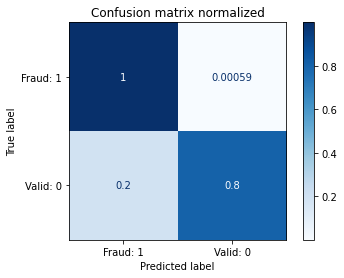

F1 score:  0.7330960854092526
Recall:  0.8046875
Precision:  0.673202614379085


In [144]:
KNN_Final = KNeighborsClassifier(n_neighbors=3) #n_neighbors=3

model_KNNF, prediction_KNNF= Classification(KNN_Final, X_ros, Y_ros, X_test, Y_test)


# Influential variables

As an inpiration,  [source](https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail) used random forest classifier to find influential variables and we found in the documentation how to use [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) as well as examples [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html). <br>

Running the code, we  can appreciate the eight most valuable features of our model along with thier percentage of importance as: V14, V11, V12, V3, V17, V16, V4 and V10. We can apprecite how these are the same varibles that we discussed in our previous analysis as candidates for influential variables. (section ["Distribution for the variables Vi"](./Credit card fraud1_EDA.ipynb#section_distributionsVi)) and section ["Statistics of balanced dataset"](#section_statistics_balanced_dataset) thus higly correlated variables with our class column and variables whose distributions per class are distinguishable can be considered strong candidates for influential variables<br>


Notice that the Time (Feature 0) and the Amount (Feature 29) rank quite low in the importance that seems to make sense since the time of false transactions were quite spread and the amounts spent were quite similar among the classes. 


Feature ranking:
1. feature 14 (0.128692)
2. feature 11 (0.104809)
3. feature 12 (0.098901)
4. feature 3 (0.081437)
5. feature 17 (0.064815)
6. feature 16 (0.061902)
7. feature 4 (0.057419)
8. feature 10 (0.046032)
9. feature 9 (0.042593)
10. feature 2 (0.033639)
11. feature 5 (0.033333)
12. feature 6 (0.032348)
13. feature 20 (0.027778)
14. feature 21 (0.027116)
15. feature 1 (0.022222)
16. feature 7 (0.021388)
17. feature 24 (0.019048)
18. feature 0 (0.016975)
19. feature 28 (0.015400)
20. feature 8 (0.015079)
21. feature 13 (0.012963)
22. feature 15 (0.010847)
23. feature 19 (0.008598)
24. feature 25 (0.007407)
25. feature 27 (0.006481)
26. feature 29 (0.002778)
27. feature 18 (0.000000)
28. feature 22 (0.000000)
29. feature 23 (0.000000)
30. feature 26 (0.000000)


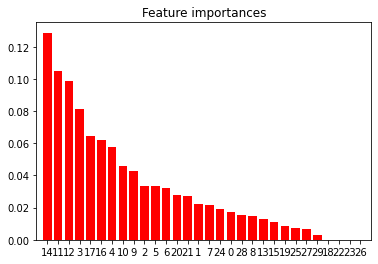

In [140]:
# Build a forest and compute the impurity-based feature importances

randomForest.fit(X_ros, Y_ros)
importances = randomForest.feature_importances_
/#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
           #  axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_ros.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_ros.shape[1]), importances[indices],
        color="r",  align="center")#yerr=std[indices],
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Accuracy: 0.9969804431024192
Confusion Matrix 
 [[85080   235]
 [   23   105]]
Confusion matrix normalized
[[0.9972455 0.0027545]
 [0.1796875 0.8203125]]


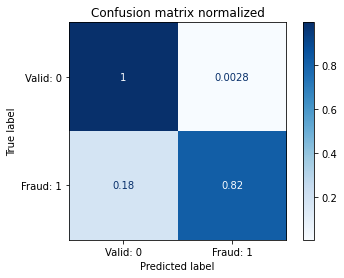

F1 score:  0.44871794871794873
Recall:  0.8203125
Precision:  0.3088235294117647
Accuracy: 0.9981976288285758
Confusion Matrix 
 [[85187   128]
 [   26   102]]
Confusion matrix normalized
[[0.99849968 0.00150032]
 [0.203125   0.796875  ]]


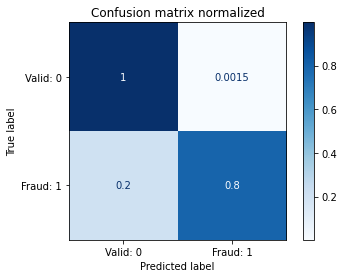

F1 score:  0.5698324022346368
Recall:  0.796875
Precision:  0.4434782608695652


(RandomForestClassifier(max_depth=2, max_samples=10, n_estimators=90),
 array([0, 0, 0, ..., 0, 0, 0]))

In [183]:

# Important=[3,4,10,11,12,14,16,17]

# Classification(randomForest, X_ros[:,Important], Y_ros, X_test[:,Important], Y_test)
# Classification(randomForest, X_ros[:,Important], Y_ros, X_test[:,Important], Y_test)


## Neural Networks
As an extra we decided to include neural networks to test the effectiveness of the model. 

In [61]:
import torch
import torch.nn.functional as F 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter

class card_NN(torch.nn.Module): # create a neural network class
    def __init__(self): # initialiser
        super().__init__() # initialise the parent class
        self.NN_layers=torch.nn.Sequential( 
        torch.nn.Linear(30, 64), # create our first linear layer
        torch.nn.ReLU(),
        torch.nn.Linear(64, 16), # create our second linear layer
        torch.nn.ReLU(),
        torch.nn.Linear(16, 2) # create our third linear layer
                            )
        
    def forward(self, x): # define the forward pass
        #x = x.view(-1, 30) # flatten out our image features into vectors
        x = self.NN_layers(x) # pass through the first linear layer
        x = F.softmax(x, dim=1) # apply activation function
        return x # return output

In [55]:
#Creating dataset for pytorch
from torch.utils.data import Dataset, DataLoader

class CardDataset(torch.utils.data.Dataset):
    def __init__(self,X_train, Y_train):
        #print(dataset.pop('mpg'))
        self.labels = Y_train 
        self.features = X_train
        #self.transform = transform
        
    def __getitem__(self, idx):
         #if self.transform:
            #return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx])
            return (torch.tensor(self.features[idx]), torch.tensor(self.labels[idx]))
        
    def __len__(self):
        return len(self.features)
    
train_data=CardDataset(X_ros, Y_ros)
train_data.labels
train_data.features[0]
train_data[0]
len(train_data)

314034

In [66]:
#Creating DataLoaders
batch_size = 512#256 #256
test_data=CardDataset(X_test, Y_test)
val_data=CardDataset(X_val, Y_val)


# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader( # create a data loader
    train_data, # what dataset should it sample from?
    shuffle=True, # should it shuffle the examples?
    batch_size=batch_size # how large should the batches that it samples be?
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

In [67]:
learning_rate = 0.001
card_model= card_NN()
card_model=card_model.double()

# CREATE OUR OPTIMISER
optimiser = torch.optim.Adam(card_model.parameters(), lr=learning_rate)


# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss()             # callable class that compares our predictions to our labels and returns our loss



writer = SummaryWriter(log_dir="runscardNN") #log_dir='../runsNN'                            # we will use this to show our models performance on a graph
# TRAINING LOOP
def train(model, epochs):
    model.train()                                  # put the model into training mode (more on this later)
    for epoch in range(epochs):
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            print('Epoch:', epoch, '\tBatch:', idx, '\tLoss:', loss.item())
            optimiser.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
    writer.close()
train(card_model, 8)
pickle.dump(card_model, open("card_model_NN.pkl", "wb"))


Epoch: 0 	Batch: 0 	Loss: 0.7165233439476589
Epoch: 0 	Batch: 1 	Loss: 0.6932846813858727
Epoch: 0 	Batch: 2 	Loss: 0.6769587023874579
Epoch: 0 	Batch: 3 	Loss: 0.6579879326204768
Epoch: 0 	Batch: 4 	Loss: 0.6481458552384358
Epoch: 0 	Batch: 5 	Loss: 0.6436542852754091
Epoch: 0 	Batch: 6 	Loss: 0.621050469125279
Epoch: 0 	Batch: 7 	Loss: 0.6203444347024225
Epoch: 0 	Batch: 8 	Loss: 0.6116566388865382
Epoch: 0 	Batch: 9 	Loss: 0.595645547764244
Epoch: 0 	Batch: 10 	Loss: 0.5998101197810348
Epoch: 0 	Batch: 11 	Loss: 0.5920766488276403
Epoch: 0 	Batch: 12 	Loss: 0.5843918429393032
Epoch: 0 	Batch: 13 	Loss: 0.5778009234020262
Epoch: 0 	Batch: 14 	Loss: 0.5718019861947472
Epoch: 0 	Batch: 15 	Loss: 0.5684931389698863
Epoch: 0 	Batch: 16 	Loss: 0.5643190491820952
Epoch: 0 	Batch: 17 	Loss: 0.5591842629174621
Epoch: 0 	Batch: 18 	Loss: 0.5476294381903117
Epoch: 0 	Batch: 19 	Loss: 0.5569472875121871
Epoch: 0 	Batch: 20 	Loss: 0.5439418820270384
Epoch: 0 	Batch: 21 	Loss: 0.5414345883024924


In [44]:
import numpy as np
            
def test(model):
    num_correct = 0
    tp,fp,fn, tn=0,0,0,0
    num_examples = len(test_data)                       # test DATA not test LOADER
    for inputs, labels in test_loader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
        tn+=int(sum((predictions==labels) & (labels==0)))
        tp+=int(sum((predictions==labels) & (labels==1)))
        fn+=int(sum((predictions!=labels) & (labels==0)))
        fp+=int(sum((predictions!=labels) & (labels==1)))
    print("Confusion matrix")
    print("True positive:", tp,"\t","False positive:",fp)
    print("False negative:", fn,"\t","True negative:", tn)
    print("-----------------------------------------------")
    recall = tp / (tp + fn)
    precision= tp / (tp + fp)
    f1= 2 * (precision*recall) / (precision+recall)


        
    percent_correct = num_correct / num_examples * 100
    print('Accuracy:', percent_correct,"%")
    print('Precision:', precision, "\n", 'Recall:', recall, "\n")
    print("F1 score:", f1)
    


## Results for NN model


In [43]:
    test(card_model)

Confusion matrix
True positive: 104 	 False positive: 24
False negative: 70 	 True negative: 85245
-----------------------------------------------
Accuracy: 99.8899851362897 %
Precision: 0.8125 
 Recall: 0.5977011494252874 

F1 score: 0.6887417218543046


# Conclusions

From all the models the best one was KNN with an F1 score: 0.754863813229572 followed by the Neural Network with F1 score: 0.6887417218543046 and Random forest with  F1 score: 0.5190839694656488. We tried to finetune our hiperparameters and although the finetunning predicted a F1 score or 0.8 for the validation set with n=72 it peformed poorly with the test dataset. One possible reason for that is that we used a reduced set given by the random undersampling dataset to train the model before evaluating in our validation set instead of the random oversample dataset.
Furthermore, we could have improved our results by eliminating more outliers using the upper and lower fences of the box plot and by combining our oversampling and undersampling techniques. Finally we found clues for the most influencial variables in our data analysis that agreed with the random forest model method to find those influencial points.
 

### Bibliography
[The 5 Most Useful Techniques to Handle Imbalanced Datasets](https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html)

[7 Techniques to Handle Imbalanced Data](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html)6. Cluster the abundant class, 5. Resample with different ratios ,4. Ensemble different resampled datasets

[How to deal with imbalanced data](https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100)
[The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
[How to handle imbalance data study in detail](https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail)

[Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)

[Detecting credit card fraud with machine learning Rafael Bastos](https://medium.com/analytics-vidhya/detecting-fraudulent-credit-card-operations-with-machine-learning-algorithms-88670bf00275)

[Detecting Credit Card Fraud Using Machine Learning Lukas Frei](https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8) Standarise Amount and Time if you want to use Logistic regression or KNN due to the weights given to the features

[Imbalanced-learn documentation](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling)


[What metrics should be used for evaluating a model on an imbalanced data set?](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba)

[Markdown for Jupyter notebooks cheatsheet](https://medium.com/@ingeh/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)
[How to use statistics to identify outliers in data](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/):Technique to eliminate more outliers automaticaly using sciit-learn


In [151]:
# #Correlations
# columns_scaled=dftest2.drop(["Time", "Class"], axis=1).columns
# df_sampling = pd.DataFrame(X_tk,  columns=columns_scaled)#index=indexes_df,
# fig = px.imshow(df_sampling.corr(), title="Heatmap variables Vi random Tomek-links")
# fig.update_layout(height=650)
# fig.show()

In [90]:
# TP=len(predictions_lr[(predictions_lr==Y_test)&(Y_test==1)])
# TN=len(predictions_lr[(predictions_lr==Y_test)&(Y_test==0)])
# FP=len(predictions_lr[(predictions_lr==1)&(Y_test==0)])
# FN=len(predictions_lr[(predictions_lr==0)&(Y_test==1)])
# print("TP:", TP, "FP:", FP, "\n")
# print("FN:",FN, "TN:",TN)
# print(len(predictions))

TP: 114 FP: 1808 

FN: 14 TN: 83507
85443
